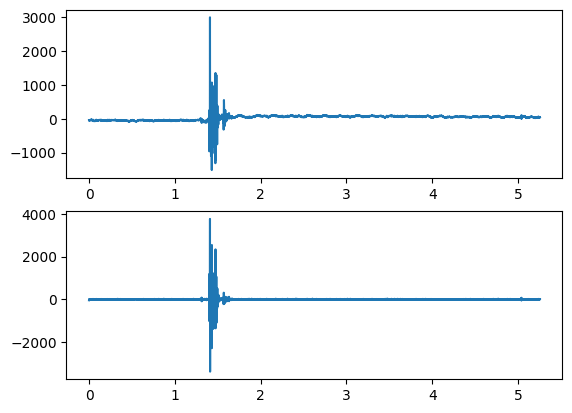

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
import pandas as pd
 
#这是一个画图函数，方便后续作图
def personal_plot(x,y):
    plt.figure(figsize=(12,6))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.plot(x,y)
    # plt.xlim(x[0],x[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.grid()

fig,ax = plt.subplots(2,1)
df = pd.read_csv('../data/white_cup_user1/20240104_091258.csv')

y = df['ACC_X'].values
t = df['Time'].values
sr = int(1/np.mean(np.diff(t)))


# 预加重
original_signal = y
pre_emphasis = 0.97
emphasized_signal = np.append(original_signal[0], original_signal[1:] - pre_emphasis * original_signal[:-1])
emphasized_signal_num = np.arange(len(emphasized_signal))

ax[0].plot(t,y)
ax[1].plot(t,emphasized_signal)
plt.show()


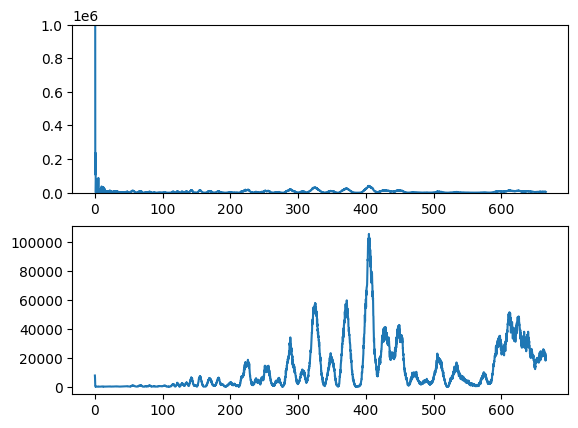

In [3]:
# 预加重频谱对比

_, axess = plt.subplots(2,1)
n = len(original_signal)
freq_pre = sr/n*np.linspace(0,n/2,int(n/2)+1)
# original = np.absolute(np.fft.rfft(original_signal,n)**2)/n 
original = np.absolute(np.fft.rfft(original_signal,n))**2/n 
# 应该是 np.absolute(np.fft.rfft(original_signal,n))**2/n ？

axess[0].plot(freq_pre,original)

n = len(emphasized_signal)
freq_after = sr/n*np.linspace(0,n/2,int(n/2)+1)
emphasied = np.absolute(np.fft.rfft(emphasized_signal,n)**2)/n
axess[1].plot(freq_after,emphasied)
# axess[1].plot(sr/n*np.arange(0,n,1),np.absolute(np.fft.fft(y,n))**2/n)


axess[0].set_ylim(-1,1000000)
# axess[1].set_ylim(-1,1000000)
plt.show()



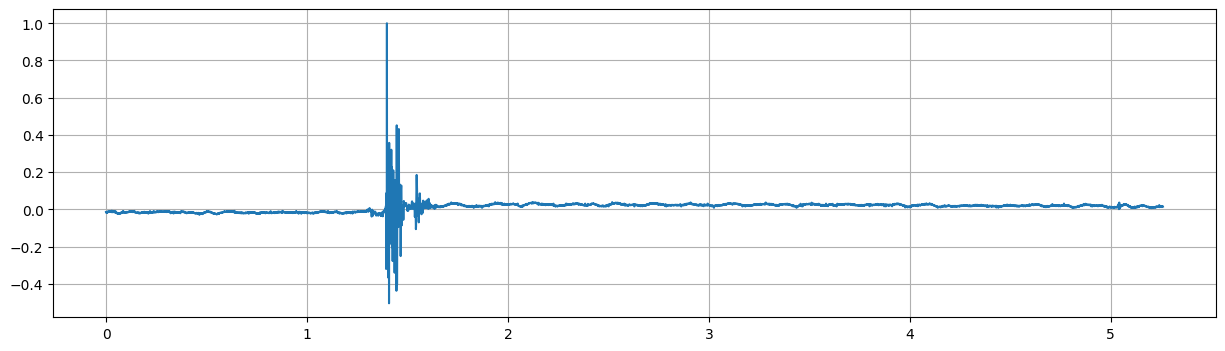

In [4]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio
sample_rate = sr
audio = normalize_audio(y)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [5]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (351, 2048)


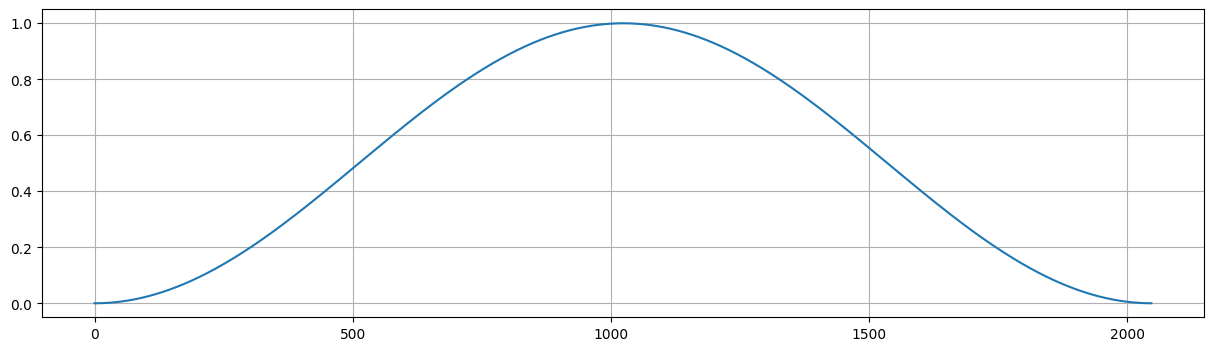

In [6]:
from scipy.signal import get_window
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

audio_win's shape:(351, 2048)


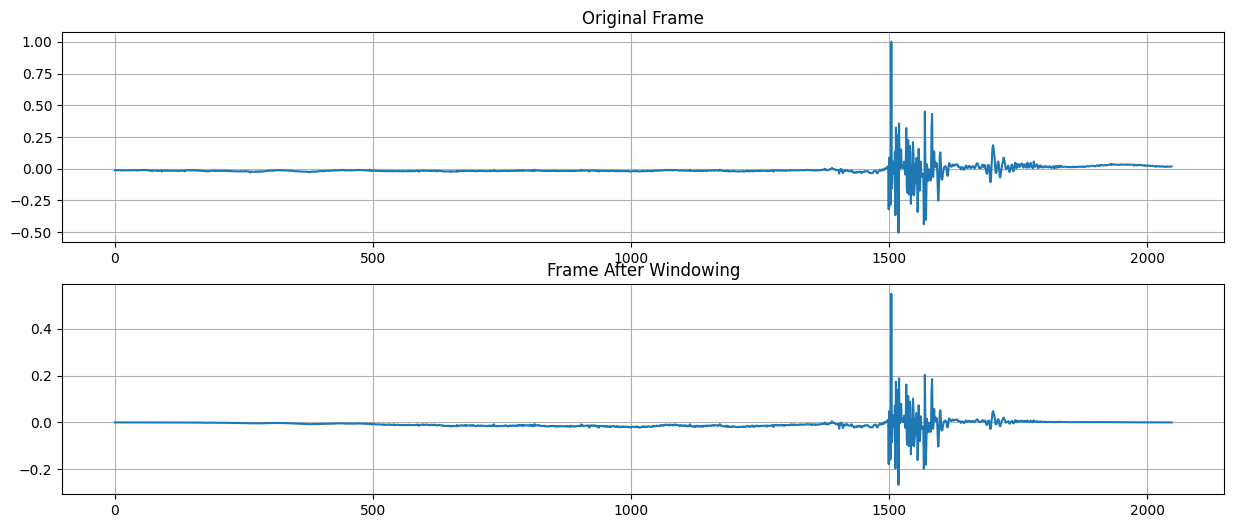

In [7]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)
print(f"audio_win's shape:{audio_win.shape}")


In [8]:
# 进行STFT
# 这种转置再转置的原因：在音频信号处理中，更习惯将时间窗口放在第一维
import scipy.fftpack as fft
audio_winT = np.transpose(audio_win) # audio_winT.shape:(2048,133)

# 创建一个空的数组 audio_fft 用于存储傅里叶变换的结果。数组的行数是 (1 + FFT_size // 2)，这是由于对称性导致 FFT 的结果只需要一半，以避免重复。列数等于音频窗口的数量
audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
# np.complex64 表示使用 64 位的复数数据类型，即每个复数由两个 32 位的浮点数表示，一个表示实部，一个表示虚部。
# order='F'：这部分指定了数组的存储顺序。'F' 表示 Fortran（列优先）顺序。在 Fortran 顺序中，多维数组的元素在内存中是列优先排列的，即列方向的元素是连续存储的。这种存储顺序在涉及到频谱分析时可能更高效，因为通常对频率进行操作时会涉及到列方向的计算。

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft) # audio_fft.shape:(133, 1025)

audio_power.shape:(351, 1025)
(351, 1025)


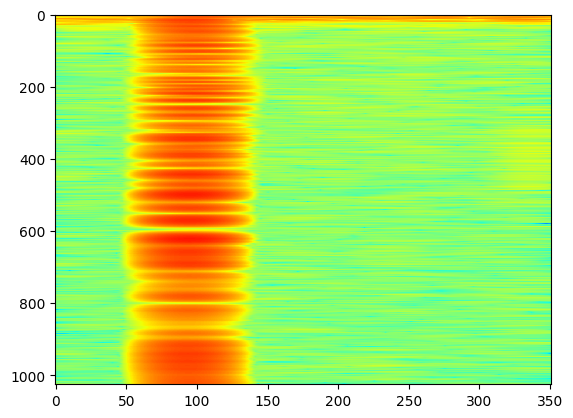

In [9]:
audio_power = np.square(np.abs(audio_fft))
print(f"audio_power.shape:{audio_power.shape}")

pow_frames = audio_power / (FFT_size/2+1) # 归一化一下，感觉FFT_size得除以2+1

print(pow_frames.shape)

plt.imshow(20*np.log10(pow_frames.T),cmap=plt.cm.jet,aspect='auto')
# plt.yticks([0,128,256,384,512],np.array([0,128,256,384,512])*sr/NFFT)


In [10]:
freq_min = 0
freq_high = 22050
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050


In [11]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    # f(m-1)和f(m)、f(m+1)分别对应第m个滤波器的起始点、中间点和结束点。大家一定要注意的一点是，这里的f(m)对应的值不是频率值，而是对应的sample的索引！比如，我们这里最大频率是22050 Hz, 所以22050Hz对应的是第513个sample，即频率f所对应的值是f/fs*NFFT
    return np.floor((FFT_size + 0.5) / sample_rate * freqs).astype(int), freqs
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([   0,   12,   28,   51,   82,  125,  184,  265,  376,  528,  737,
       1024])

(1025,)

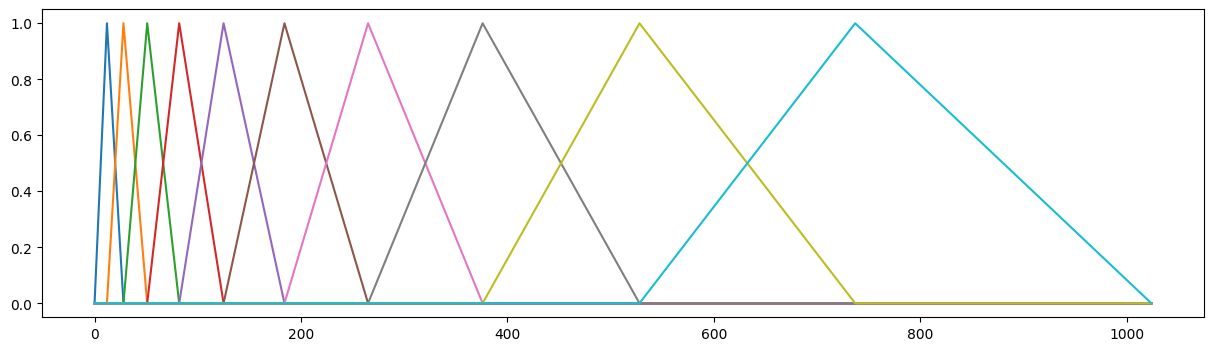

In [12]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        # 相比于原kaggle代码，增加了`endpoint=False`参数
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n], endpoint=False)
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1],endpoint=False)
    
    return filters
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])
    
# plt.xlim(-1,50)
filters[0].shape

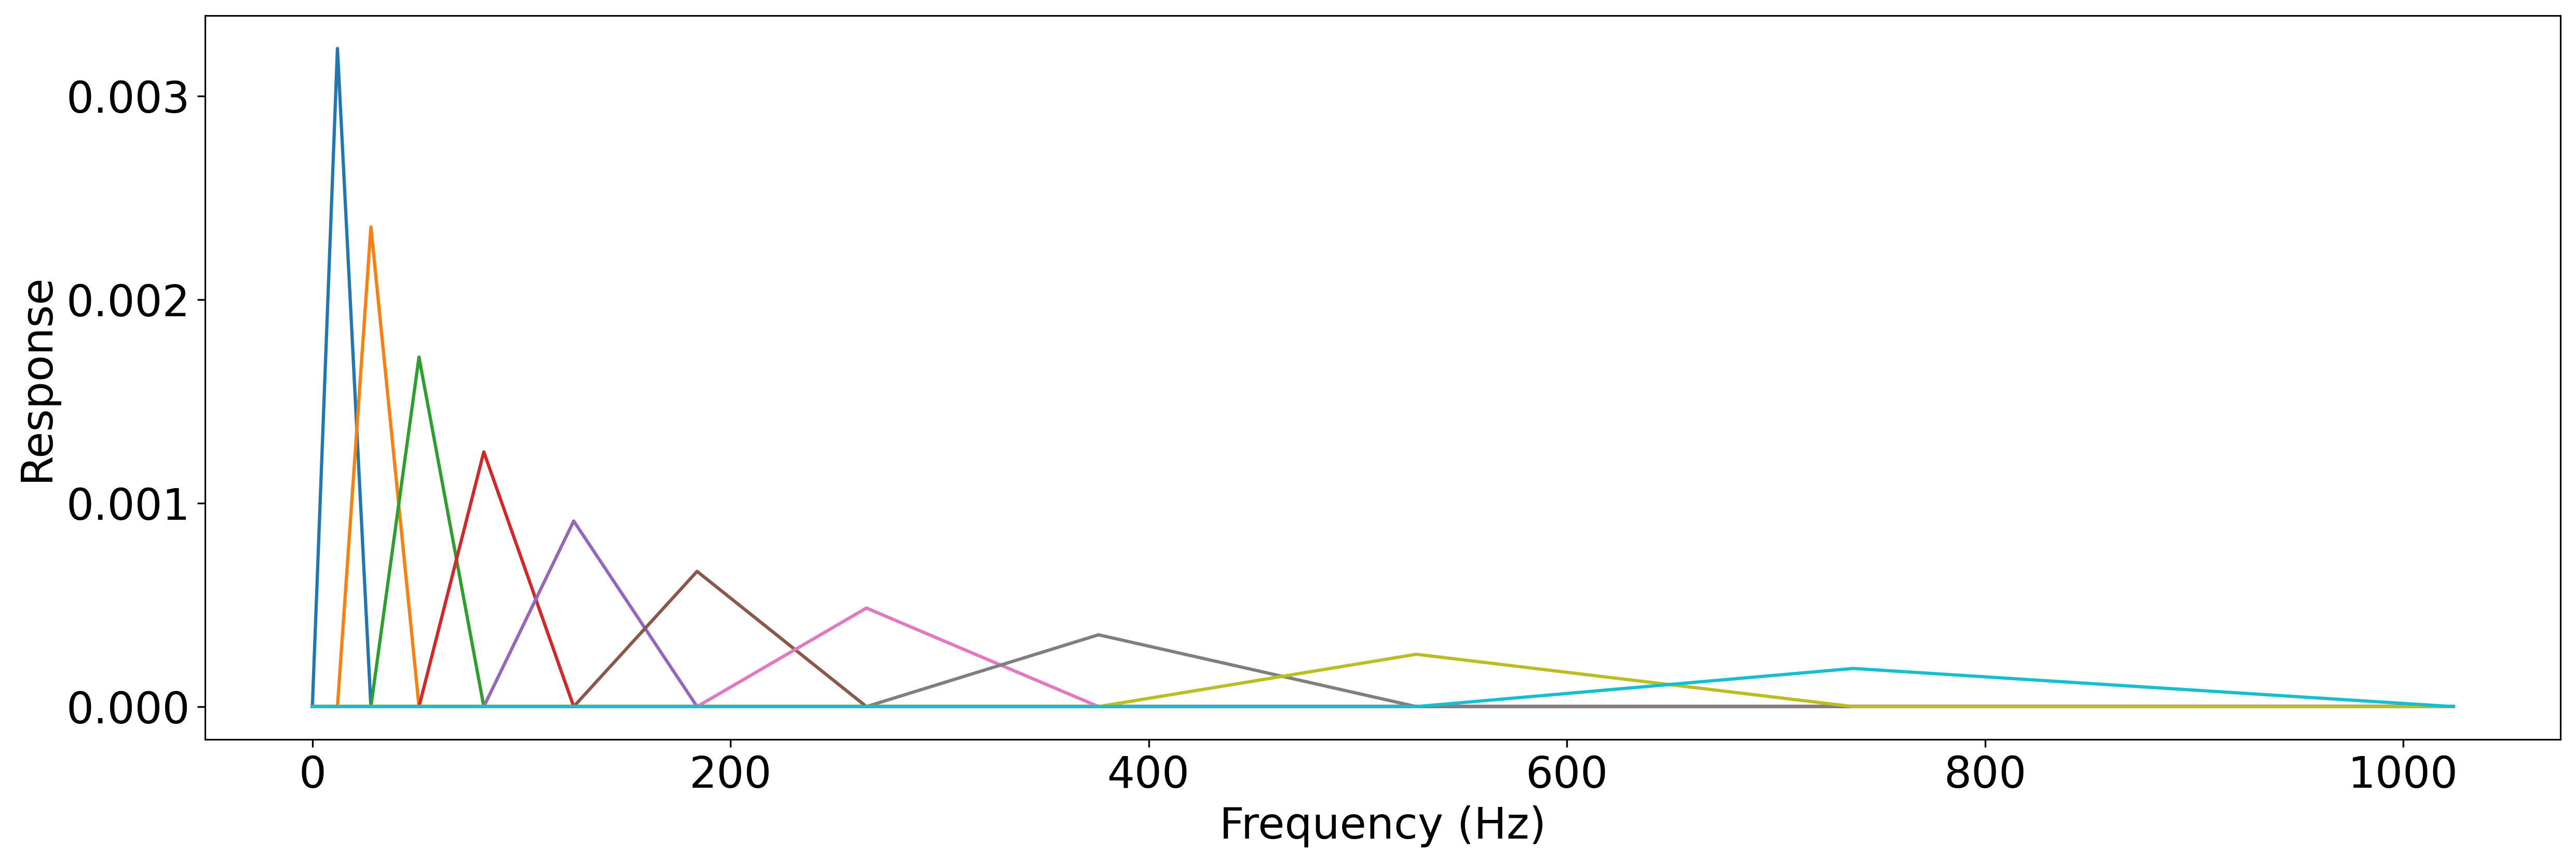

In [28]:
# 将三角形 MEL 权重除以 MEL 带的宽度（面积归一化）
# 三角形面积 = 1/2 * 底 * 高；高一致，可忽略；对每个filter乘以面积的倒数
# 如果我们不对滤波器进行归一化，我们会看到由于滤波器宽度的原因，噪声随着频率的增加而增加。
# enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
# filters *= enorm[:, np.newaxis] # np.newaxis用于增加一个维度，可以与filter的向量元素做内积
plt.figure(figsize=(17,6),dpi=300)
for n in range(filters.shape[0]):
    plt.plot(filters[n])
# plt.xlim(-1,50)
plt.rc('font', size=22, family='DejaVu Sans') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.ylabel('Response')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()  # 调整图表的布局
plt.savefig('./filters.png')

In [63]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered) # 有其他代码使用20？
audio_log.shape

(10, 133)

In [64]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape
# cepstral_coefficents[:, 0]

(40, 133)

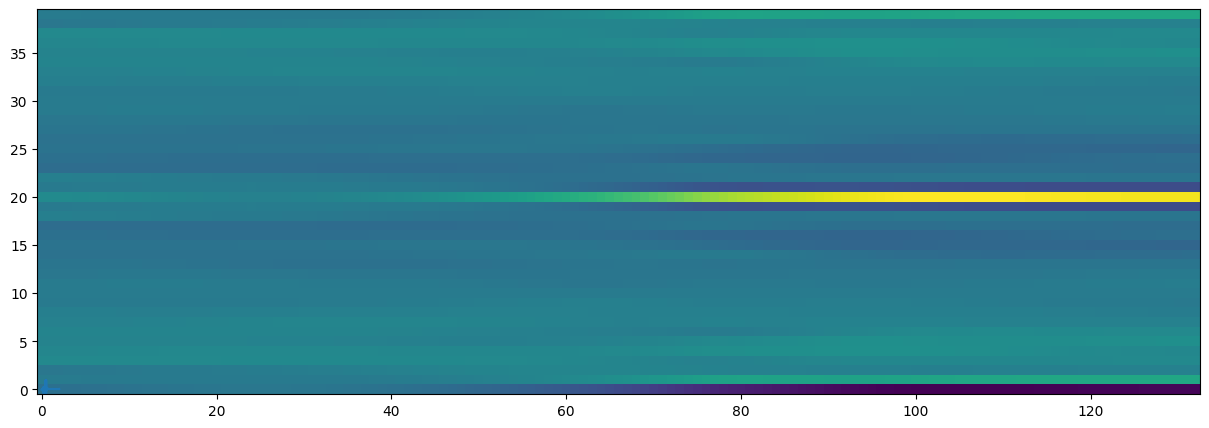

In [65]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');